# 설정

In [1]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "PCA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA 개요

<div style="text-align:center;">
    "데이터들을 정사영시켜 차원을 낮춘다면, 어떤 벡터에 데이터들을 정사영시켜야 원래의 데이터 구조를 제일 잘 유지할 수 있을까?"
</div>

<b>PCA</b><sup>Principal Component Analysis</sup>는 가장 대표적인 차원 축소 방법이다. 주로 특성 추출과 차원 축소 용도로 많은 분야에서 널리 사용한다. PCA를 많이 사용하는 애플리케이션에는 탐색적 데이터 분석과 주식 거래 시장의 잡음 제거, 생물정보학 분야에서 게놈(genome) 데이터나 유전자 발현(gene expression) 분석 등이 있다.

PCA는 여러 변수 간에 존재하는 상관관계를 기반으로 하여 데이터에 있는 특성(주성분<sup>Principal Component</sup>)을 추출해 차원을 축소하는 기법이다. PCA로 차원을 축소할 때는 기존 데이터의 정보 유실이 최소화되는 것이 당연하다. 이를 위해서 PCA는 가장 높은 분산을 가지는 데이터의 축을 찾고 좀 더 작거나 같은 수의 차원을 갖는 새로운 부분 공간으로 이를 투영한다. 새로운 부분 공간의 직교 좌표(주성분)는 주어진 조건하에서 분산이 최대인 방향으로 해석할 수 있다(즉, 분산이 데이터의 특성을 가장 잘 나타내는 것으로 간주한다). 덧붙이자면, 주성분 분석은 특성들이 통계적으로 상관관계가 없도록 데이터셋을 회전시키는 기술이다.

예를 들어, 키와 몸무게 2개의 피처를 가지고 있는 데이터 세트가 다음과 같이 구성돼 있다고 가정해 보겠다.

<div style="text-align:center;">
    <img src="./images/PCA/ex1.png">
</div>

이 2개의 피처를 한 개의 주성분을 가진 데이터 세트로 차원 축소를 할 수 있다. <u>데이터 변동성이 가장 큰 방향으로 축을 생성하고, 새롭게 생성된 축으로 데이터를 투영하는 방식이다.</u>

<div style="text-align:center;">
    <img src="./images/PCA/ex2.png">
</div>

<u>PCA는 제일 먼저 가장 큰 데이터 변동성<sup>Variance</sup>을 기반으로 첫 번째 벡터 축을 생성하고, 두 번째 축은 이 벡터 축에 직각이 되는 벡터(직교 벡터)를 축으로 한다. 세 번째 축은 다시 두 번째 축과 직각이 되는 벡터를 설정하는 방식으로 축을 생성한다. 이렇게 생성된 벡터 축에 원본 데이터를 투영하면 벡터 축의 개수만큼의 차원으로 원본 데이터가 차원 축소된다.</u>

<div style="text-align:center;">
    <img src="./images/PCA/ex3.png">
</div>

<mark>PCA, 즉 주성분 분석은 이처럼 원본 데이터의 피처 개수에 비해 매우 작은 주성분으로 원본 데이터의 총 변동성을 대부분 설명할 수 있는 분석법이다.</mark>

PCA를 사용하여 차원을 축소하기 위해 $d \times k$ 차원의 변환 행렬 $\mathrm{W}$를 만든다. 이 행렬로 샘플 벡터 $\mathrm{x}$를 새로운 $k$ 차원의 특성 부분 공간으로 매핑한다. 이 부분 공간은 원본 $d$차원의 특성 공간보다 작은 차원을 갖는다.

$$
\mathrm{x} = [x_1, x_2, ..., x_d],\,\,x\in\mathbb{R}^d\\
\downarrow \mathrm{xW},\,\,\mathrm{W}\in\mathbb{R}^{d\times k}\\
\mathrm{z} = [z_1, z_2, ..., z_d], \,\, \mathrm{z}\in\mathbb{R}^k
$$

원본 $d$ 차원 데이터를 새로운 $k$ 차원의 부분 공간(일반적으로 $k << d$)으로 변환하여 만들어진 첫 번째 주성분이 가장 큰 분산을 가질 것이다. 다른 말로, 특성들의 상관관계가 가장 큰 방향이다. 모든 주성분은 다른 주성분들과 상관관계가 없다는(직교한다는) 제약하에 가장 큰 분산을 갖는다. 입력 특성에 상관관계가 있더라도 만들어진 주성분은 서로 직각을 이룰(상관관계가 없을) 것이다. PCA 방향은 데이터 스케일에 매우 민감하다. 특성의 스케일이 다르고 모든 특성의 중요도를 동일하게 취급하려면 PCA를 적용하기 전에 특성을 표준화 전처리해야 한다.

PCA를 선형대수 관점에서 해석해 보면, 입력 데이터의 공분산 행렬<sup>Covariance Matrix</sup>을 고유값 분해하고, 이렇게 구한 교유벡터에 입력 데이터를 선형 변환하는 것이다. 이 고유벡터가 PCA의 주성분 벡터로서 입력 데이터의 분산이 큰 방향을 나타낸다. 고윳값<sup>eigenvalue</sup>은 바로 이 고유벡터의 크기를 나타내며, 동시에 입력 데이터의 분산을 나타낸다. 이 의미를 좀 더 자세히 알아보기 위해 선형 변환, 공분산 행렬과 고유벡터에 대해 알아보겠다.

일반적으로 선형 변환은 특정 벡터에 행렬 A를 곱해 새로운 벡터로 변환하는 것을 의미한다. 이를 특정 벡터를 하나의 공간에서 다른 공간으로 투영하는 개념으로도 볼 수 있으며, 이 경우 이 행렬을 바로 공간으로 가정하는 것이다.

보통 분산은 한 개의 특정한 변수의 데이터 변동을 의미하나, 공분산은 두 변수 간의 변동을 의미한다. 즉, 사람 키 변수를 X, 몸무게 변수 Y라고 하면 공분산 Cov(X, Y) > 0은 X(키)가 증가할 때 Y(몸무게)도 증가한다는 의미다. <mark>공분산 행렬은 여러 변수와 관련된 공분산을 포함하는 정방형 행렬이다.</mark>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-amwm">X</th>
    <th class="tg-amwm">Y</th>
    <th class="tg-amwm">Z</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-amwm">X</td>
    <td class="tg-amwm">3.0</td>
    <td class="tg-baqh">-0.71</td>
    <td class="tg-baqh">-0.24</td>
  </tr>
  <tr>
    <td class="tg-amwm">Y</td>
    <td class="tg-baqh">-0.71</td>
    <td class="tg-amwm">4.5</td>
    <td class="tg-baqh">0.28</td>
  </tr>
  <tr>
    <td class="tg-amwm">Z</td>
    <td class="tg-baqh">-0.24</td>
    <td class="tg-baqh">0.28</td>
    <td class="tg-amwm">0.91</td>
  </tr>
</tbody>
</table>

위 표에서 보면 공분산 행렬에서 대각선 원소는 각 변수(X, Y, Z)의 분산을 의미하며, 대각선 이외의 원소는 가능한 모든 변수 쌍 간의 공분산을 의미한다. X, Y, Z의 분산은 각각 3.0, 4.0, 0.91이다. X와 Y의 공분산은 -0.71, X와 Z의 공분산은 -0.24, Y와 Z의 공분산은 0.28이다.

고유벡터는 행렬 A를 곱하더라도 방향이 변하지 않고 그 크기만 변하는 벡터를 지칭한다. 즉, $\mathrm{Ax = ax}$(A는 행렬, x는 고유벡터, a는 스칼라값)이다. 이 고유벡터는 여러 개가 존재하며, 정방 행렬은 최대 그 차원 수만큼의 고유벡터를 가질 수 있다. 예를 들어 2x2 행렬은 두 개의 고유벡터를, 3x3 행렬은 3개의 고유벡터를 가질 수 있다. 이렇게 고유벡터는 행렬이 작용하는 힘의 방향과 관계가 있어서 행렬을 분해하는 데 사용된다.

공분산 행렬은 정방행렬<sup>Diagonal Matrix</sup>이며 대칭행렬<sup>Symmetric Matrix</sup>이다. 정방행렬은 열과 행이 같은 행렬을 지칭하는데, 정방행렬 중에서 대각 원소를 중심으로 원소 값이 대칭되는 행렬, 즉 A<sup>T</sup> = A인 행렬을 대칭행렬이라고 부른다. 공분산 행렬은 개별 분산값을 대각 원소로 하는 대칭행렬이다. 이 대칭행렬은 고유값 분해와 관련해 매우 좋은 특성이 있다. 대칭행렬은 항상 고유벡터를 직교행렬<sup>orthogonal matrix</sup>로, 고유값을 정방 행렬로 대각화할 수 있다는 것이다.

입력 데이터의 공분산 행렬을 C라고 하면 공분산 행렬의 특성으로 인해 다음과 같이 분해할 수 있다.

$$
\mathrm{C} = \mathrm{P}\sum\mathrm{P}^T
$$

이때 P는 $n \times n$의 직교행렬이며, $\Sigma$는 $n \times n$ 정방행렬, P<sup>T</sup>는 행렬 P의 전치 행렬이다. 위 식은 고유벡터 행렬과 고유값 행렬로 다음과 같이 대응된다. 

$$
\mathrm{C} = [e_1 \cdots e_n]\begin{bmatrix}
\lambda_1 & \cdots & 0 \\
\cdots & \cdots & \cdots \\
0 & \cdots & \lambda_n \\
\end{bmatrix}\begin{bmatrix}
e_1^t \\
\vdots \\
e_n^t\end{bmatrix}
$$

즉, 공분산 C는 고유벡터 직교 행렬 x 고유값 정방 행렬 x 고유벡터 직교 행렬의 전치 행렬로 분해된다. $e_i$는 $i$번째 고유벡터를, $\lambda_i$는 $i$번째 고유벡터의 크기를 의미한다. $e_1$는 가장 분산이 큰 방향을 가진 고유벡터이며, $e_2$는 $e_1$에 수직이면서 다음으로 가장 분산이 큰 방향을 가진 고유벡터다.

위 수식이 어떻게 유도됐는지는 더 복잡한 수학식을 동원해야 하기에 여기서는 생략한다. 선형대수식까지 써가면서 강조하고 싶었던 것은 <b>입력 데이터의 공분산 행렬이 고유벡터와 고유값으로 분해될 수 있으며, 이렇게 분해된 고유벡터를 이용해 입력 데이터를 선형 변환하는 방식이 PCA라는 것이다.

차원 축소를 위한 PCA 알고리즘을 자세히 알아보기 전에 사용할 방법을 몇 단계로 나누어 정리해 보겠다.

<ol>
    <li>$d$ 차원 데이터셋을 표준화 전처리한다.</li>
    <li>공분산 행렬을 만든다.</li>
    <li>공분산 행렬을 고유 벡터와 고윳값으로 분해한다.</li>
    <li>고윳값을 내림차순으로 정렬하고 그에 해당하는 고유 벡터의 순위를 매긴다.</li>
    <li>고윳값이 가장 큰 $k$개의 고유 벡터를 선택한다. 여기서 $k$는 새로운 특성 부분 공간의 차원이다($k \leq d$).</li>
    <li>최상위 $k$개의 고유 벡터로 투영 행렬<sup>projection matrix</sup> $\mathrm{W}$를 만든다.</li>
    <li>투영 행렬 $\mathrm{W}$를 사용해서 $d$ 차원 입력 데이터셋 $\mathrm{X}$를 새로운 $k$ 차원의 특성 부분 공간으로 변환한다.</li>
</ol>

## 주성분 추출 단계

이 절에서 PCA 처음 네 단계를 처리한다.

<ol>
    <li>데이터를 표준화 전처리한다.</li>
    <li>공분산 행렬을 구성한다.</li>
    <li>공분산 행렬의 고윳값과 고유 벡터를 구한다.</li>
    <li>고윳값을 내림차순으로 정렬하여 고유 벡터의 순위를 매긴다.</li>
</ol>

PCA는 많은 속성으로 구성된 원본 데이터를 그 핵심을 구성하는 데이터로 압축한 것이다. 이를 확인하기 위해 Wine 데이터셋을 로드하겠다.

In [2]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


그다음 Wine 데이터셋을 70%와 30% 비율로 훈련 세트와 테스트 세트로 나누고 표준화를 적용하여 단위 분산을 갖도록 한다.

In [3]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)
# 특성을 표준화 전처리한다.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

앞 코드를 실행하여 필수적인 전처리 단계를 완료한 후 공분산 행렬을 만드는 두 번째 단계를 진행한다. 공분산 행렬은 $d \times d$ 차원의 대칭 행렬로 특성 상호 간의 공분산을 저장한다. $d$는 데이터셋에 있는 차원 개수다. 예를 들어 전체 샘플에 대한 두 턱성 $x_j$와 $x_k$ 사이의 공분산은 다음 식으로 계산할 수 있다.

$$
\sigma_{jk} = \frac{1}{n}\sum_{i=1}^n(x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)
$$

여기서 $\mu_j$와 $\mu_k$는 특성 $j$와 $k$의 샘플 평균이다. 데이터셋을 표준화 전처리했기 때문에 샘플 평균은 0이다. 두 특성 간 양의 공분산은 특성이 함께 증가하거나 감소하는 것을 나타낸다. 반면, 음의 공분산은 특성이 반대 방향으로 달라진다는 것을 나타낸다. 예를 들어 세 개의 특성으로 이루어진 공분산 행렬은 다음과 같이 쓸 수 있다.

$$
\sum = \begin{bmatrix}
\sigma_1^2 & \sigma_{12} & \sigma_{13} \\
\sigma_{21} & \sigma_2^2 & \sigma_{23} \\
\sigma_{31} & \sigma_{32} & \sigma_3^2 \\
\end{bmatrix}
$$

공분산 행렬의 고유 벡터가 주성분(최대 분산의 방향)을 표현한다.<sup><a id="a01" href="#p01">[1]</a></sup> 이에 대응되는 고윳값은 주성분의 크기다. Wine 데이터셋의 경우 13 x 13 차원의 공분산 행렬로부터 13개의 고유 벡터와 고윳값을 얻을 수 있다.

이제 세 번째 단계를 위해 공분산 행렬의 고유 벡터와 고윳값의 쌍을 구해 보자. 고유 벡터 $\mathrm{v}$는 다음 식을 만족한다.

$$
\Sigma\mathrm{v} = \lambda\mathrm{v}
$$

여기서 $\lambda$는 스케일을 담당하는 고윳값이다. 고유 벡터와 고윳값을 직접 계산하는 것은 복잡한 작업이기 때문에 넘파이의 <code>linalg.eig</code> 함수를 사용하여 Wine 데이터셋의 공분산 행렬에 대한 고유 벡터와 고윳값 쌍을 계산하겠다.<sup><a id="a02" href="#p02">[2]</a></sup>

In [4]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n고윳값 \n%s' % eigen_vals)


고윳값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


<code>numpy.cov</code> 함수를 사용하여 표준화 전처리된 훈련 데이터셋의 공분산 행렬을 계산한다. 그다음 <code>linalg.eig</code> 함수를 사용하여 고윳값 분해를 수행한다. 이를 통해 13개의 고윳값이 들어 있는 벡터(eigen_vals)와 각 고윳값에 대응하는 고유 벡터가 열에 저장된 13 x 13 차원의 행렬(eigen_vecs)을 얻는다.<sup><a id="a03" href="#p03">[3]</a></sup>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: green"><strong>NOTE_</strong></span>numpy.linalg.eig 함수는 대칭과 비대칭 정방 행렬<sup>square matrix</sup>을 모두 다룰 수 있지만 이따금 복소수 고윳값을 반환한다. 이와 비슷하게 에르미트 행렬<sup>Hermetian matrix</sup><sup><a id="a04" href="#p04">[4]</a></sup>을 분해하기 위해 구현된 numpy.linalg.eigh 함수는 공분산 행렬과 같은 대칭 행렬을 다룰 때 수치적으로 더 안정된 결과를 만든다. 즉, numpy.linalg.eigh는 항상 실수 고윳값을 반환한다.
</div>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: green"><strong>NOTE_</strong></span>사이킷런의 PCA 클래스는 직접 고윳값과 고유 벡터를 계산하는 대신 특이값 분해<sup>singular value decomposition</sup> 방식을 사용하여 주성분을 구한다. 원점에 중앙이 맞춰진 공분산 행렬을 특이값 분해로 표현하면 다음과 같다.
    $$
    \text{Cov} = \frac{1}{n-1}\mathrm{X^TX} = \frac{1}{n-1}(\mathrm{U}\Sigma\mathrm{V}^T)^T(\mathrm{U}\Sigma\mathrm{V}^T) = \frac{1}{n-1}(\mathrm{V}\Sigma\mathrm{U}^T)(\mathrm{U}\Sigma\mathrm{V}^T) = \frac{1}{n-1}\mathrm{V}\Sigma^2\mathrm{V}^T = \mathrm{V}\frac{\Sigma^2}{n-1}\mathrm{V}^T
    $$
    따라서 $\mathrm{V}$가 공분산 행렬의 고유 벡터고 주성분이 된다. 사이킷런의 PCA는 scipy.linalg.svd 함수를 사용하여 주성분 $\mathrm{V}$를 구한다. 이 식에서 $\Sigma$는 공분산 행렬이 아니라 행렬 X와 같은 크기의 대각 행렬을 나타낸다.<br><br>
    공식에서 볼 수 있듯이 고윳값은 특이값 $\Sigma$를 제곱하여 (샘플 개수 - 1)로 나누어 계산할 수 있다. 사이킷런은 (샘플 개수 - 1)이 아닌 샘플 개수로 나누는 버그를 가지고 있었다. 0.20 버전에서 (샘플 개수 - 1)로 수정되었고 특이값을 저장하는 singular_values_ 속성도 추가되었다.<br><br>
    사이킷런의 PCA는 scipy.linalg.svd 함수를 사용하여 주성분 $\mathrm{V}$를 구한다. 다만 scipy.linalg.svd나 numpy.linalg.svd 함수에서 반환되는 U, s, V 값 중에서 V가 SVD 공식 $\mathrm{U\Sigma V}^T$의 $\mathrm{V}^T$이다.
</div>

## 총분산과 설명된 분산

데이터셋 차원을 새로운 특성 부분 공간으로 압축하여 줄여야 하기에 가장 많은 정보(분산)를 가진 고유 벡터(주성분) 일부만 선택한다. 고윳값은 고유 벡터의 크기를 결정하므로 고윳값을 내림차순으로 정렬한다. 고윳값 순서에 따라 최상위 $k$개의 고유 벡터를 선택한다. 가장 정보가 많은 $k$개의 고유 벡터를 선택하기 전에 고윳값의 설명된 분산<sup>explained variance</sup> 비율을 그래프로 그려 보자. 고윳값 $\lambda_j$의 설명된 분산 비율은 전체 고윳값의 합에서 고윳값 $\lambda_j$의 비율이다.

$$
\frac{\lambda_j}{\sum_{j=1}^d\lambda_j}
$$

넘파이 <code>cumsum()</code> 함수로 설명된 분산의 누적 합을 계산하고 맷플롯립의 <code>step()</code> 함수로 그래프를 그려보겠다.

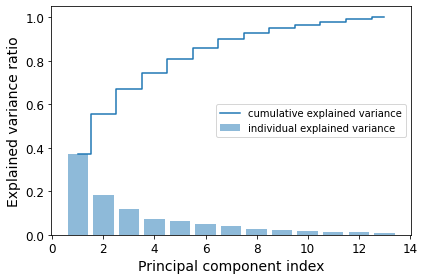

In [5]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
           sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

결과 그래프는 첫 번째 주성분이 거의 분산의 40%를 커버하고 있음을 보여 준다. 또 처음 두 개의 주성분이 데이터셋에 있는 분산의 대략 60%를 설명한다.

설명된 분산 그래프가 랜덤 포레스트로 계산한 특성 중요도를 떠올리게 하지만 PCA는 비지도 학습이란 점을 기억하자. 클래스 레이블에 관한 정보는 사용하지 않았다. 랜덤 포레스트는 클래스 소속 정보를 사용하여 노드의 불순도를 계산하는 반면<sup><a id="a05" href="#p05">[5]</a></sup> 분산은 특성 축을 따라 값들이 퍼진 정도를 측정한다.

## 특성 변환

공분산 행렬을 고유 벡터와 고윳값 쌍으로 성공적으로 분해한 후 Wine 데이터셋을 새로운 주성분 축으로 변환하는 나머지 세 단계를 진행해 보자. 이 절에서 진행할 남은 단계는 다음과 같다.

<ol start="5">
    <li>고윳값이 가장 큰 $k$개의 고유 벡터를 선택한다. 여기서 $k$는 새로운 특성 부분 공간의 차원이다($k\leq d$).</li>
    <li>최상위 $k$개의 고유 벡터로 투영 행렬 $\mathrm{W}$를 만든다.</li>
    <li>투영 행렬 $\mathrm{W}$를 사용해서 $d$ 차원 입력 데이터셋 $\mathrm{X}$를 새로운 $k$ 차원의 특성 부분 공간으로 변환한다.</li>
</ol>

좀 더 쉽게 설명하면 고윳값의 내림차순으로 고유 벡터를 정렬하고 선택된 고유 벡터로 투영 행렬을 구성한다. 이 투영 행렬을 사용하여 데이터를 저차원 부분 공간으로 변환한다.

먼저 고윳값의 내림차순으로 고유 벡터와 고윳값의 쌍을 정렬하겠다.

In [6]:
# (고윳값, 고유 벡터) 튜플의 리스트를 만든다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
# 높은 값에서 낮은 값으로 (고유값, 고유 벡터) 튜플을 정렬한다
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

다음 가장 큰 두 개의 고윳값에 해당하는 고유 벡터를 선택한다. 이 데이터셋에 있는 분산의 약 60%를 잡아낼 수 있을 것이다. 이 예제에서는 나중에 2차원 산점도를 그리기 위해 두 개의 고유 벡터만 선택했다. 실전에서는 계산 효율성과 모델 성능 사이의 절충점을 찾아 주성분 개수를 결정해야 한다.

In [7]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


앞 코드를 실행하여 최상위 두 개의 고유 벡터로부터 13 x 2 차원의 투영 행렬 $\mathrm{W}$를 만든다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: green"><strong>NOTE_</strong></span>사용하는 넘파이와 LAPACK 버전에 따라 부호가 반대인 행렬 $\mathrm{W}$를 얻을 수 있다. 이는 문제가 아니다. 만약 $\mathrm{v}$가 행렬 $\Sigma$의 고유 벡터이면 다음과 같다.
    $$
    \Sigma\mathrm{v} = \lambda\mathrm{v}
    $$
    여기서 $\mathrm{v}$는 고유 벡터고 $\mathrm{-v}$ 또한 고유 벡터다. 다음과 같이 기초대수학을 사용하면 방정식의 양쪽에 $\alpha$를 곱할 수 있다.
    $$
    \alpha\Sigma\mathrm{v} = \alpha\lambda\mathrm{v}
    $$
    행렬 곱셈은 스칼라 곱셈에 대해 결합법칙이 성립하므로 다음과 같이 다시 정렬할 수 있다.
    $$
    \Sigma(\alpha\mathrm{v}) = \lambda(\alpha\mathrm{v})
    $$
    이렇게 쓰면 $\alpha\mathrm{v}$는 $\alpha=1$과 $\alpha=-1$일 때 같은 고윳값 $\lambda$를 갖는 고유 벡터임을 알 수 있다.

투영 행렬을 사용하면 샘플 $x$(1 x 13 차원의 행 벡터)를 PCA 부분 공간(두 개의 주성분)을 투영하여 $x'$를 얻을 수 있다. 두 개의 특성으로 구성된 2차원 샘플 벡터다.

$$
x' = x\mathrm{W}
$$

In [8]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

비슷하게 전체 124 x 13 차원의 훈련 데이터셋을 행렬 점곱으로 두 개의 주성분으로 변환할 수 있다.

$$
\mathrm{X}' = \mathrm{XW}
$$

In [9]:
X_train_pca = X_train_std.dot(w)
X_train_pca.shape

(124, 2)

마지막으로 124 x 2 차원의 행렬로 변환된 Wine 훈련 세트를 2차원 산점도로 시각화해보자.

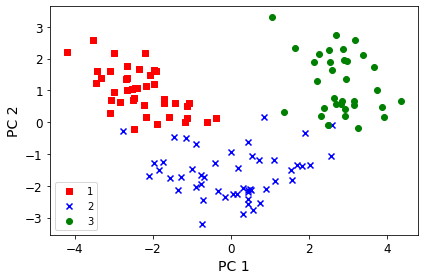

In [10]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

결과 그래프에서 볼 수 있듯이 데이터가 y축(두 번째 주성분)보다 x축(첫 번째 주성분)을 따라 더 넓게 퍼져 있다. 이전 절에서 만든 설명된 분산의 그래프와 동일한 결과다.<sup><a id="a06" href="#p06">[6]</a></sup> 선형 분류기가 클래스들을 잘 분리할 수 있을 것 같다고 직관적으로 알 수 있다.

산점도를 그리기 위한 목적으로 클래스 레이블 정보를 인코딩했지만 PCA는 어떤 클래스 레이블 정보도 사용하지 않는 비지도 학습 기법이라는 점을 잊지 말자.

## 사이킷런의 주성분 분석

이전 절에서처럼 단계별로 PCA를 구현해 보면 PCA의 작동 원리를 이해하는 데 도움이 된다. 이제는 사이킷런에 구현된 PCA 클래스를 사용하는 법을 알아보겠다. PCA 클래스는 사이킷런의 변환기 클래스 중 하나다. 훈련 데이터를 사용하여 모델을 훈련하고 같은 모델 파라미터를 사용하여 훈련 데이터와 테스트 데이터를 변환한다. PCA 클래스는 생성 파라미터로 n_components를 입력받는다. n_components는 PCA로 변환할 차원의 수를 의미한다. 이후에 <code>fit()</code>과 <code>transform()</code>을 호출해 PCA로 변환을 수행한다.

사이킷런의 PCA 클래스를 Wine 데이터셋의 훈련 세트에 적용하고 로지스틱 회귀로 변환된 샘플 데이터를 분류해 보겠다.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_23224\3161197038.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl, 0],


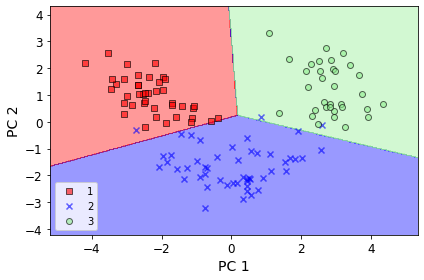

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # 마커와 컬러맵을 준비한다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그린다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # 클래스 샘플을 표시한다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y=X[y==cl, 1],
                    alpha=0.6,
                    c=cmap.colors[idx],
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)
        
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

종종 사이킷런의 PCA 투영과 직접 만든 PCA 구현을 비교하면 두 그래프는 거울에 비친 것처럼 뒤집혀 있을 경우가 있다. 이는 두 그래프 중 하나에 문제가 있기 때문이 아니고 계산 방법에 따라 고유 벡터는 음수나 양수 부호를 가질 수 있기 때문이다. 이것이 문제가 되지 않지만 필요하다면 데이터에 -1을 곱해서 이미지를 뒤집을 수 있다. 고유 벡터는 일반적으로 단위 길이가 1이 되도록 정규화되어 있다. 예제를 마무리하기 위해 테스트 세트를 변환하고 로지스틱 회귀가 클래스를 잘 구분하는지 결정 경계를 그려 보자.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_23224\3161197038.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl, 0],


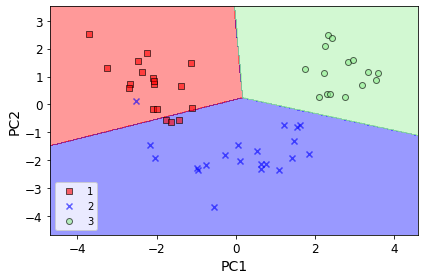

In [12]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

로지스틱 회귀가 2차원 특성 부분 공간에서 매우 잘 작동한다는 것을 알 수 있다. 테스트 데이터셋에 있는 샘플 몇 개만 분류하지 못했다.

PCA의 단점은 그래프의 두 축을 해석하기가 쉽지 않다는 점이다. 주성분은 원본 데이터에 있는 어떤 방향에 대응하는 여러 특성이 조합된 형태다. 잠시 후에 보겠지만 이런 조합이 보통 매우 복잡하다. PCA 객체가 학습할 때 components_ 속성에 주성분이 저장된다.

In [13]:
print("PCA 주성분 형태:", pca.components_.shape)

PCA 주성분 형태: (2, 13)


components_의 각 행은 주성분 하나씩을 나타내며 중요도에 따라 정렬되어 있다(맨 처음 주성분이 가장 위에 나타난다). 열은 원본 데이터의 특성에 대응하는 값이다.

In [14]:
print("PCA 주성분:", pca.components_)

PCA 주성분: [[-0.13724218  0.24724326 -0.02545159  0.20694508 -0.15436582 -0.39376952
  -0.41735106  0.30572896 -0.30668347  0.07554066 -0.32613263 -0.36861022
  -0.29669651]
 [ 0.50303478  0.16487119  0.24456476 -0.11352904  0.28974518  0.05080104
  -0.02287338  0.09048885  0.00835233  0.54977581 -0.20716433 -0.24902536
   0.38022942]]


예를 들면 첫 번째 주성분을 정의하는 단위 벡터는 <code>pca.components_.T[:, 0]</code>이다.

In [15]:
pca.components_.T[:, 0]

array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651])

### 설명된 분산의 비율

explained_variance_ratio_ 변수에 저장된 주성분의 <b>설명된 분산의 비율</b><sup>explained variance ratio</sup>도 유용한 정보 중 하나다. 이 비율은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다. 예를 들어 위에서 구한 pca에 나타난 처음 두 주성분에 대한 설명된 분산의 비율을 살펴보겠다.

In [16]:
pca.explained_variance_ratio_

array([0.36951469, 0.18434927])

이는 데이터셋 분산의 37%가 첫 번째 PC를 따라 놓여 있고 18.4%가 두 번째 PC를 따라 놓여 있음을 알려준다.

전체 주성분의 설명된 분산 비율을 알고 싶다면 n_components 매개변수를 None으로 지정하고 PCA 클래스의 객체를 만들면 된다. 이렇게 하면 explained_variance_ratio_ 속성에서 모든 주성분의 설명된 분산 비율을 확인할 수 있다.

In [17]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

PCA 클래스의 객체를 만들 때 n_components=None으로 지정했기 때문에 차원 축소를 수행하는 대신 분산의 크기 순서대로 모든 주성분이 반환된다.

## 신용카드 고객 데이터 세트 적용

이 절에서 다룰 credit_card.xls 데이터 세트를 DataFrame으로 로딩하겠다. 판다스는 엑셀 파일을 DataFrame으로 편리하게 로드하기 위해 <code>read_excel()</code>을 제공한다. 로드하려는 엑셀 파일명과 데이터가 있는 엑셀 시트명을 입력하면 된다(해당 데이터 세트가 있는 엑셀 시트명은 'Data'이다).

In [18]:
# header로 의미 없는 첫 행 제거, iloc로 기존 id 제거
import pandas as pd

df = pd.read_excel('./datasets/credit_card.xls', header=1, sheet_name='Data').iloc[:, 1:]
print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


신용카드 데이터 세트는 30,000개의 레코드와 24개의 속성을 가지고 있다. 이 중에서 'default payment next month' 속성이 Target 값으로 '다음달 연체 여부'를 의미하며 '연체'일 경우 1, '정상납부'가 0이다. 원본 데이터 세트에 PAY_0 다음에 PAY_2 칼럼이 있으므로 PAY_0 칼럼을 PAY_1으로 칼럼명을 변환하고 'default payment next month' 칼럼도 칼럼명이 너무 길어서 'default'로 칼럼명을 변경한다. 이후 Target 속성인 'default' 칼럼을 y_target 변수로 별도로 저장하고 피처 데이터는 이 default 칼럼을 제외한 별도의 DataFrame으로 만들겠다.

In [19]:
df.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'default'}, inplace=True)
y_target = df['default']
X_features = df.drop('default', axis=1)

해당 데이터 세트는 23개의 속성 데이터 세트가 있으나 각 속성끼리 상관도가 매우 높다. DataFrame의 <code>corr()</code>를 이용해 각 속성 간의 상관도를 구한 뒤 이를 시본의 heatmap으로 시각화하겠다.

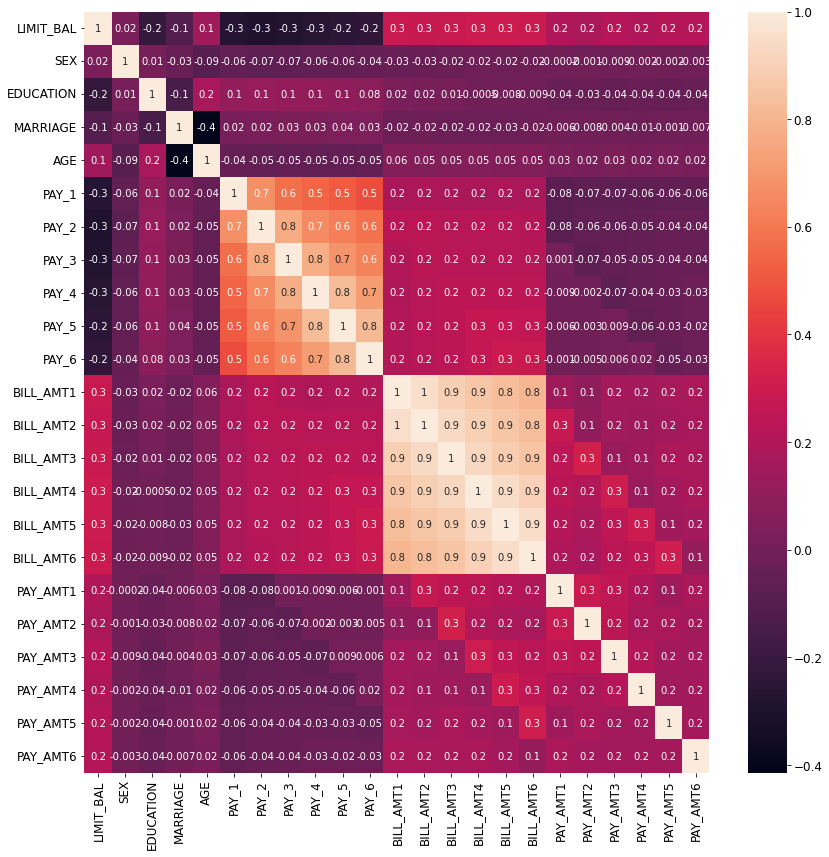

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_features.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt='.1g');

BILL_AMT1 ~ BILL_AMT6 6개 속성끼리 상관도가 대부분 0.9 이상으로 매우 높음을 알 수 있다. 이보다는 낮지만 PAY_1 ~ PAY_6까지의 속성 역시 상관도가 높다. 이렇게 높은 상관도를 가진 속성들은 소수의 PCA만으로도 자연스럽게 이 속성들의 변동성을 수용할 수 있다. 이 BILL_AMT1 ~ BILL_AMT6까지 6개 속성을 2개의 컴포넌트로 PCA 변환한 뒤 개별 컴포넌트의 변동성을 explained_variance_ratio_ 속성으로 알아보겠다.

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# BILL_AMT1 ~ BILL_AMT6까지 6개의 속성명 생성
cols_bill = ['BILL_AMT' + str(i) for i in range(1, 7)]
print('대상 속성명:', cols_bill)

# 2개의 PCA 속성을 가진 PCA 객체 생성하고, explained_variance_ratio_ 계산을 위해 fit() 호출
scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
pca = PCA(n_components=2)
pca.fit(df_cols_scaled)
print('PCA Component별 변동성:', pca.explained_variance_ratio_)

대상 속성명: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PCA Component별 변동성: [0.90555253 0.0509867 ]


단 2개의 PCA 컴포넌트만으로도 6개 속성의 변동성을 약 95% 이상 설명할 수 있으며 특히 첫 번째 PCA 축으로 90%의 변동성을 수용할 정도로 이 6개 속성의 상관도가 매우 높다.

이번에는 원본 데이터 세트와 6개의 컴포넌트로 PCA 변환할 데이터 세트의 분류 예측 결과를 상호 비교해 보겠다. 먼저 원본 데이터 세트에 랜덤 포레스트를 이용해 타깃 값인 디폴트 값을 3개의 교차 검증 세트로 분류 예측했다.

In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3)

print('CV=3인 경우의 개별 Fold세트별 정확도:', scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3인 경우의 개별 Fold세트별 정확도: [0.8083 0.8196 0.8232]
평균 정확도:0.8170


3개의 교차 검증 세트에서 평균 예측 정확도는 약 81.7%를 나타냈다. 이번에는 6개의 컴포넌트로 PCA 변환한 데이터 세트에 대해서 동일하게 분류 예측을 적용해 보겠다.

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 원본 데이터 세트에 먼저 StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# 6개의 컴포넌트를 가진 PCA 변환을 수행하고 cross_val_score()로 분류 예측 수행.
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)

print('CV=3인 경우의 PCA 변환된 개별 Fold 세트별 정확도:', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도:{0:.4f}'.format(np.mean(scores_pca)))

CV=3인 경우의 PCA 변환된 개별 Fold 세트별 정확도: [0.7909 0.7984 0.8009]
PCA 변환 데이터 세트 평균 정확도:0.7967


전체 23개 속성의 약 1/4 수준인 6개의 PCA 컴포넌트만으로도 원본 데이터를 기반으로 한 분류 예측 결과보다 약 1\~2% 정도의 예측 성능 저하만 발생했다. 1~2%의 예측 성능 저하는 미비한 성능 저하로 보기는 힘들지만, 전체 속성의 1/4 정도만으로도 이정도 수치의 예측 성능을 유지할 수 있다는 것은 PCA의 뛰어난 압축 능력을 잘 보여주는 것이라고 생각된다.

이제 components_ 속성으로 주성분을 하나씩 살펴보자. 앞서 열은 원본 데이터의 특성에 대응하는 값이라고 했다. 이 예에서는 "LIMIT_BAL", "SEX" 등이다. components_ 값을 한번 출력해보겠다.

In [24]:
print("PCA 주성분:", pca.components_)

PCA 주성분: [[ 0.06851844 -0.02165645  0.01920561 -0.00560026  0.01423152  0.16108185
   0.19411971  0.20021311  0.20703825  0.21096045  0.20641232  0.33438516
   0.34579702  0.34977713  0.3538832   0.35175238  0.34451435  0.09423121
   0.07868089  0.0863942   0.07779272  0.07535443  0.06994814]
 [ 0.31632269  0.03059462 -0.09152241 -0.04325091  0.06657802 -0.29812117
  -0.33482226 -0.34389566 -0.34458178 -0.33160005 -0.30579308  0.13981426
   0.14022638  0.14621315  0.14545014  0.14376158  0.141873    0.14910982
   0.13987165  0.15156977  0.1414089   0.13719058  0.1293967 ]
 [ 0.01744175  0.02403097 -0.31641768  0.45318739 -0.46234721 -0.01737022
   0.01769259  0.06165246  0.08890731  0.10872139  0.11090856 -0.15091922
  -0.12708411 -0.08392722 -0.07049503 -0.05653602 -0.0475099   0.28188296
   0.30182262  0.28028563  0.23737519  0.19427258  0.20932151]
 [ 0.06998354 -0.07823055  0.24658454 -0.44456153  0.4627527   0.01596067
   0.04986381  0.08427755  0.10936514  0.11556927  0.10989722 

이 값을 히트맵으로 시각화하면 이해하기 더 쉬울 수 있다.

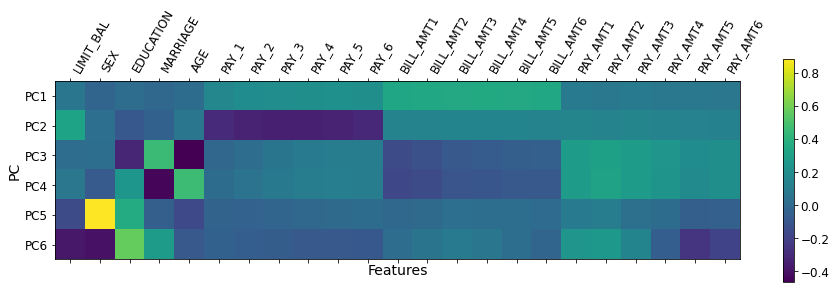

In [25]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks(np.arange(0, 6), ["PC" + str(i) for i in range(1, 7)])
plt.colorbar()
plt.xticks(range(len(X_features.columns)),
           X_features.columns, rotation=60, ha='left')
plt.xlabel("Features")
plt.ylabel("PC")
plt.show()

# 고유얼굴(eigenface) 특성 추출

PCA는 특성 추출에도 이용한다. 특성 추출은 원본 데이터 표현보다 분석하기에 더 적합한 표현을 찾을 수 있으리란 생각에서 출발한다. 이미지를 다루는 애플리케이션은 특성 추출이 도움이 될만한 좋은 사례다. 이미지는 적색, 녹색, 청색(RGB)의 강도가 기록된 픽셀로 구성된다. 보통 이미지 안의 물체는 수천 개의 픽셀로 이뤄지며 함께 모여 있을 때 의미가 있다.

PCA를 이용하여 LFW<sup>Labeled Faces in the Wild</sup> 데이터셋의 얼굴 이미지에서 특성을 추출하는 아주 간단한 애플리케이션을 만들어보겠다. 이 데이터셋은 인터넷에서 내려받은 유명 인사들의 얼굴 이미지들로 2000년 초반 이후의 정치인, 가수, 운동선수들의 얼굴을 포함한다. 이번 예제에서는 처리 속도를 높이고자 흑백 이미지를 사용하고<sup><a id="a07" href="p07">[7]</a></sup> 스케일을 줄였다. 다음 코드로 그중 몇 개의 샘플을 보였다.

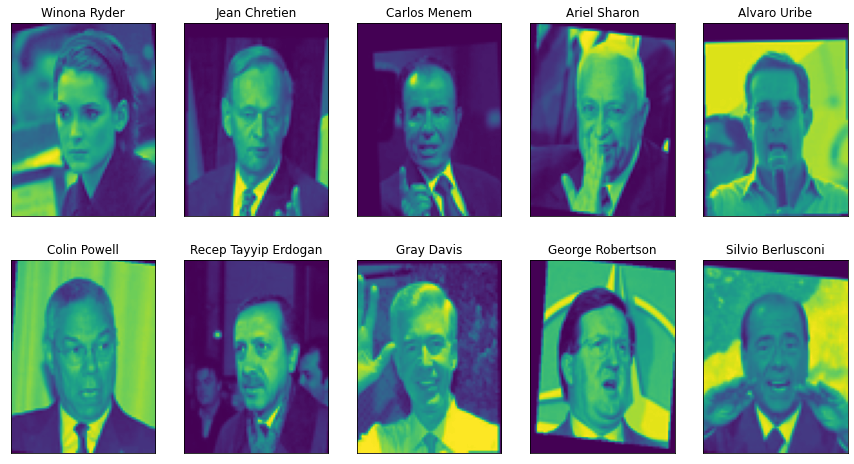

In [55]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

LFW 데이터셋에는 62명의 얼굴을 찍은 이미지가 총 3,023개 있으며 각 이미지의 크기는 87 x 65픽셀이다.

In [28]:
print("people.images.shape:", people.images.shape)
print("클래스 개수:", len(people.target_names))

people.images.shape: (3023, 87, 65)
클래스 개수: 62


그런데 이 데이터셋은 조금 편중되어서, 다음에서 볼 수 있듯이 조지 부시<sup>George W Bush</sup>와 콜린 파월<sup>Colin Powell</sup>의 이미지가 많다.

In [29]:
# 각 타깃이 나타난 횟수 계산
counts = np.bincount(people.target)
# 타깃별 이름과 횟수 출력
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

데이터셋의 편중을 없애기 위해 사람마다 50개의 이미지만 선택하겠다(이렇게 하지 않으면 조지 부시 이미지에 치우친 특성이 추출된다).

In [44]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0 ~ 255 사이의 흑백 이미지의 픽셀 값을 0 ~ 1 스케일로 조정한다.
# MinMaxScaler를 적용하는 것과 거의 같다.
X_people = X_people / 255.

얼굴 인식이라 하면 통상적으로 새로운 얼굴 이미지가 데이터베이스에 있는 기존 얼굴 중 하나에 속하는지 찾는 작업이다. 사진 애플리케이션, 소셜 미디어, 보안 애플리케이션들이 이에 속한다. 해결 방법 중 하나는 각 사람을 서로 다른 클래스로 구분하는 분류기로 만드는 것이다. 하지만 보통 얼굴 데이터베이스에는 사람의 수는 많지만 각 사람에 대한 이미지는 적다(즉 클래스별 훈련 데이터가 너무 적다). 이런 문제 때문에 대부분의 분류기를 훈련 시키기 어렵다. 그리고 대규모 모델을 다시 훈련시키지 않고도 새로운 사람의 얼굴을 쉽게 추가할 수도 있어야 한다.

간단한 방법으로, 분류하려는 얼굴과 가장 비슷한 얼굴 이미지를 찾는 1-최근접 이웃 분류기를 사용할 수 있다. 이 분류기는 원칙적으로 클래스마다 하나의 훈련 샘플을 사용한다. KNeighborsClassifier가 얼마나 잘 적용되는지 보겠다.

In [45]:
from sklearn.neighbors import KNeighborsClassifier
# 데이터를 훈련 세트와 테스트 세트로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
# 이웃 개수를 한 개로 하여 KNeighborsClassifier 모델을 만든다.
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("1-최근접 이웃의 테스트 세트 점수: {:.2f}".format(knn.score(X_test, y_test)))

1-최근접 이웃의 테스트 세트 점수: 0.14


정확도가 14%이다. 클래스 62개를 분류하는 문제에서 아주 나쁜 결과는 아니지만(무작위로 분류하는 정확도는 1/62 = 1.6%이다). 그렇다고 좋은 결과도 아니다. 7번에 한 번 꼴로만 올바르게 인식한다.

그래서 PCA가 필요하다. 얼굴의 유사도를 측정하기 위해 원본 픽셀 공간에서 거리를 계산하는 것은 매우 나쁜 방법이다. 픽셀을 사용해서 두 이미지를 비교할 때, 각 픽셀의 회색톤 값을 다른 이미지에서 동일한 취이에 있는 픽셀 값과 비교한다. 이런 방식은 사람이 얼굴 이미지를 인식하는 것과는 많이 다르고, 픽셀을 있는 그대로 비교하는 방식으로는 얼굴의 특징을 잡아내기가 어렵다. 예를 들어 픽셀을 비교할 때 얼굴 위치가 한 픽셀만 오른족으로 이동해도 큰 차이를 만들어 완전히 다른 얼굴로 인식하게 된다. 그래서 주성분으로 변환하여 거리를 계산하면 정확도가 높아지지 않을까 기대해본다. 여기서는 PCA의 <b>화이트닝</b><sup>whietening</sup> 옵션을 사용해서 주성분의 스케일이 같아지도록 조정한다. 이는 화이트닝 옵션 없이 변환한 후에 StandardScaler를 적용하는 것과 같다.<sup><a id="a08" href="#p08">[8]</a></sup> 화이트닝 옵션으로 데이터가 회전하는 것뿐만 아니라 스케일도 조정되어 그래프가 (퉝니 아닌) 원 모양으로 바뀌었다.

<div style="text-align:center;">
    <img src="./images/PCA/whitening.png">
</div>

PCA 객체를 훈련 데이터로 학습시켜서 처음 100개의 주성분을 추출한다. 그런 다음 훈련 데이터와 테스트 데이터를 변환한다.

In [48]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape:", X_train_pca.shape)

X_train_pca.shape: (1547, 100)


새 데이터는 처음 100개의 주성분에 해당하는 특성을 가진다. 이제 이 데이터를 사용해 1-최근접 이웃 분류기로 이미지를 분류해보겠다.

In [50]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("테스트 세트 정확도: {:.2f}".format(knn.score(X_test_pca, y_test)))

테스트 세트 정확도: 0.15


모델의 정확도가 14%에서 15%로 약간 향상되었다. 원래는 모델의 정확도가 약 8~9% 향상되어 주성분이 데이터를 더 잘표현한다고 직관적으로 판단하게끔 전개해야 하지만, 이미지를 불러오는 과정에서 달라진 부분이 조금 있는 것 같다. 아마 불러온 이미지가 얼굴 뿐만 아니라 증명사진 처럼 상반신이 나오고, 사진 바깥 부분의 검정 배경도 포함돼 있어서 그런 것 같다.

이미지 데이터일 경우엔 계산한 주성분을 쉽게 시각화할 수 있다. 주성분이 나타내는 것은 입력 데이터 공간에서의 어떤 방향이라는 것을 기억하자. 입력 차원은 87 x 65 픽셀의 흑백 이미지이고, 따라서 이 공간의 어떤 방향도 87 x 65 픽셀의 흑백 이미지다.<sup><a id="a09" href="#p09">[9]</a></sup>

몇 개의 주성분을 확인해보겠다.

pca.components_.shape: (100, 5655)


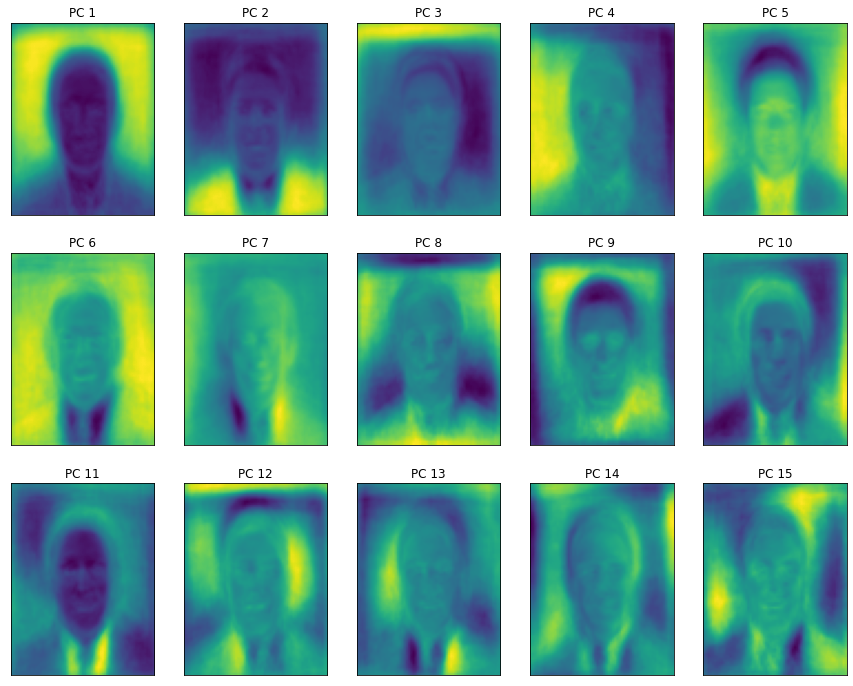

In [59]:
print("pca.components_.shape:", pca.components_.shape)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                          subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("PC {}".format(i + 1))

이 주성분들을 완전하게 이해할 순 없지만 몇몇 주성분이 잡아낸 얼굴 이미지의 특징을 짐작해볼 수 있다. 첫 번째 주성분은 얼굴과 배경의 명암 차이를 기록한 것으로 보이며, 두 번째 주성분은 옷과 옷이 아닌 부분 조명의 차이를 담고 있는 것 등이다. 이런 방식이 원본 픽셀 값을 사용하는 것보다 더 의미 있지만, 여전히 사람이 얼굴을 인식하는 방식과는 거리가 멀다. 이 PCA 모델은 픽셀을 기반으로 하므로, (눈, 볼, 코의 위치 같은) 얼굴의 배치와 조명이 두 이미지가 얼마나 비슷한지 판단하는 데 큰 영향을 준다. 하지만 사람이라면 얼굴의 배치나 조명부터 인지하지는 않는다. 사람은 얼굴의 비슷한 정도를 평가할 때 나이, 성별, 표정, 머리 모양 같이 픽셀의 강도로 표현하기 어려운 속성들을 사용한다. 알고리즘이 데이터를 해석하는 방식은 사람의 방식과는 상당히 다르다는 것을 꼭 기억해두어야 한다(특히 이미지같이 사람에게는 친숙한 시각 데이터일 경우).

어쨋든 PCA를 계속 사용해보겠다. PCA 변환은 데이터를 회전시키고 분산이 작은 주성분을 덜어내는 것이라고 했다. 또 다른 좋은 해석 방법은 테스트 포인트를 주성분의 가중치 합으로 나타내는 데 필요한 수치(PCA 변환 뒤의 새로운 특성값)를 찾는 것으로 해석할 수 있다.<sup><a id="a10" href="#p10">[10]</a></sup>

<b>그림 1</b> 이미지를 주성분의 가중치 합으로 분해한 PCA 구성도
<div style="text-align:center;">
    <img src="./images/PCA/eigenface_pca.png">
</div>

위 그림의 $z_{n1}$과 $z_{n2}$은 이 데이터 포인트에 대한 주성분의 계수다. 다른 말로 하면, 이 이미지가 회전된 공간에 적용된 값이다.

PCA 모델을 이해하는 또 다른 방법은 몇 개의 주성분을 사용해 원본 데이터를 재구성해보는 것이다. 각 주성분을 제거하거나 회전시키고 평균을 더하는 등 원래 데이터 공간에 새로운 포이트로 옮기는 방식을 얼굴 데이터셋에 적용해서 몇 개의 주성분으로 데이터를 줄이고 원래 공간으로 되돌릴 수 있다. 원래 특성 공간으로 되돌리는 작업은 <code>inverse_transform()</code> 메서드를 사용한다. 다음 그림은 10, 50, 100, 500개의 주성분을 사용해 얼굴 이미지를 재구성한 것이다.

<b>그림 2</b> 주성분 개수에 따른 세 얼굴 이미지의 재구성
<div style="text-align:center;">
    <img src="./images/PCA/eigenface_reverse.jpg">
</div>

주성분을 10개만 사용했을 땐 얼굴의 각도, 조명 같은 이미지의 기본 요소만 나타난다. 주성분을 더 많이 사용할수록 이미지가 더욱 상세해진다. 이는 [그림 1]의 식에 덧셈 항을 더 추가하는 것과 같다. 주성분을 픽셀 수만큼 사용하면 변환 후에 어떤 정보도 잃지 않게 되므로 이미지를 완벽하게 재구성할 수 있다.

PCA의 처음 두 주성분을 이용해 전체 데이터를 누구의 얼굴인지 클래스로 구분해 산점도에 나타낼 수도 있다.

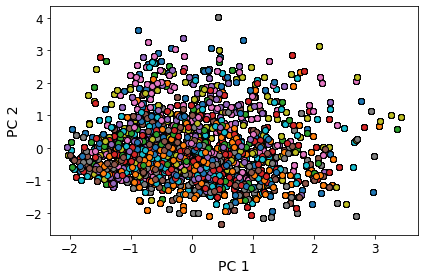

In [68]:
for cl in y_train:
    plt.scatter(x=X_train_pca[y_train == cl, 0],
                y=X_train_pca[y_train == cl, 1],
                edgecolor='black')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

주성분을 두 개만 사용했을 땐 전체 데이터가 한 덩어리로 뭉쳐 있어 클래스가 잘 구분되지 않는다. [그림 2]에서 10개의 주성분을 사용했을 때도 PCA는 얼굴의 아주 대략적인 특징만 잡았기 때문에 이런 그래프가 당연해 보인다.

# MNIST로의 적용

앞서 PCA의 동작 방식과 활용의 예인 eigenface를 살펴봤다. PCA는 데이터의 변동성이 데이터를 가장 잘 나타내는 성질로 생각하여 원본 데이터셋의 차원보다 적은 차원으로 축소하는 데이터 압축 기법이다. 여기서 축소할 차원 수를 임의로 정하기 보다는 충분한 분산(예를 들면 95%)이 될 때까지 더해야 할 차원 수를 선택하는 것이 간단하다. 물론 데이터 시각화를 위해 차원을 축소하는 경우에는 차원을 2개나 3개로 줄이는 것이 일반적이다.

우선 <code>fetch_openml()</code> 함수로 mnist 데이터셋을 불러와 학습셋과 테스트셋으로 분리한다.

In [72]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

다음 코드는 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산한다.

In [73]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

d

154

그런 다음 n_components=d로 설정하여 PCA를 다시 실행한다. 하지만 유지하려는 주성분의 수를 지정하기보다는 보존하려는 분산의 비율을 n_components에 0.0에서 1.0 사이로 설정하는 편이 훨씬 낫다.

In [76]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
np.sum(pca.explained_variance_ratio_)

0.9504179414881005

또 다른 방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것이다(그냥 cumsum을 그래프로 그리면 된다.). 일반적으로 이 그래프에는 설명된 분산의 빠른 성장이 멈추는 변곡점이 있다. 여기서는 차원을 약 100으로 축소해도 설명된 분산을 크게 손해보지 않을 것이다.

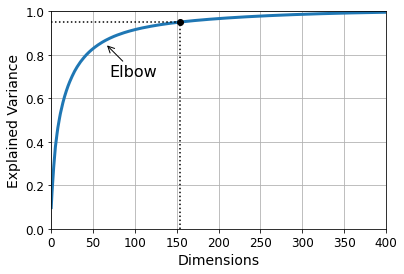

In [89]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

# 압축을 위한 PCA

차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어든다. 예를 들어 MNIST 데이터셋에 분산의 95%를 유지하도록 PCA를 적용해보겠다. 각 샘플은 원래의 784개의 특성이 아니라 150개 정도만 가지고 있을 것이다. 대부분의 분산은 유지되었지만 데이터셋은 원본 크기의 20% 미만이 되었다. 이는 상당한 압축률이고 이런 크기 축소는 (SVM 같은) 분류 알고리즘의 속도를 크게 높일 수 있다.

또한 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있다. 투영에서 일정량의 정보(유실된 5%의 분산)를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없다. 하지만 원본 데이터와 매우 비슷할 것이다. 원본 데이터와 재구성된 데이터(압축 후 원복한 것) 사이의 평균 제곱 거리를 <b>재구성 오차</b><sup>reconstruction error</sup>라고 한다.

다음 코드는 MNIST 데이터셋을 154차원으로 압축하고 <code>inverse_transform()</code> 메서드를 사용해 784차원으로 복원한다.

In [90]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가한다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    
    # 배열의 크기를 바꾸어 28 x 28 이미지를 담은 그리드로 구성한다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

# 미주

<b id="p01">1</b> 원점에 중앙이 맞춰진 행렬 $\mathrm{X}$가 있고 이 행렬의 주성분 벡터를 $\mathrm{w}$라고 가정한다. $\mathrm{X}$를 $\mathrm{w}$에 투영한 $\mathrm{Xw}$의 분산이 최대가 되는 $\mathrm{w}$를 찾으려 한다. 분산$(\mathrm{Xw}) = \frac{1}{(n-1)}(\mathrm{Xw})^T\mathrm{Xw} = \mathrm{w}^T\frac{1}{(n-1)}\mathrm{X}^T\mathrm{Xw} = \mathrm{w}^T\mathrm{Cw}$처럼 공분산 행렬 $\mathrm{C}$로 표현된다. 분산($\mathrm{Xw}$)를 $\lambda$로 놓으면 $\mathrm{Cw} = \lambda\mathrm{w}$처럼 쓸 수 있다. 즉, 공분산 행렬의 가장 큰 고윳값($\lambda$)에 해당하는 벡터 $\mathrm{w}$를 찾는 문제가 된다.

<b id="p02">2</b> <code>np.cov</code> 함수는 특성이 열에 놓여 있을 것으로 기대하므로 훈련 데이터를 전치해서 전달한다.

<b id="p03">3</b> 13개의 고윳값 합은 1이다. 고유 벡터는 원본 특성 공간에서 어떤 방향을 나타낸다. 원본 데이터셋의 특성이 13개이므로 고유 벡터의 차원도 13이다.

<b id="p04">4</b> 에르미트 행렬은 실수 대칭 행렬을 복소수로 일반화한 것이다. 전치 행렬의 각 원소를 켤레 복소수로 만든 켤레 전치 행렬이 자기 자신과 같은 행렬을 말한다.

<b id="p05">5</b> 결정 트리의 특성 중요도는 노드에 사용된 특성별로 (부모 노드의 샘플 비율 x 불순도) - (왼쪽 자식 노드의 샘플 비율 x 불순도) - (오른쪽 자식 노드의 샘플 비율 x 불순도)를 계산하여 더하고, 특성 중요도의 합이 1이 되도록 정규화한 것이다. 여기서 샘플 비율은 전체 샘플 개수에 대한 비율이다. 랜덤 포레스트의 특성 중요도는 각 결정 트리 특성 중요도의 합을 트리 개수로 나눈 것이다.

<b id="p06">6</b> 주성분은 고윳값의 크기로 정렬하기 때문에 첫 번째 주성분이 가장 큰 분산을 가진다.

<b id="p07">7</b> <code>fetch_lfw_people</code> 함수는 기본값으로 흑백 이미지를 사용하게 되어 있다. 컬러 이미지를 사용하려면 color=True 옵션을 주어 호출해야 한다.

<b id="p08">8</b> PCA로 변환된 데이터의 표준편차는 linalg.svd 함수에서 반환된 특잇값 배열 s를 샘플 개수의 제곱근으로 나누어 구할 수 있다. 화이트닝 옵션은 PCA 변환을 할 때 이 표준편차를 나누어 적용한다. PCA 변환은 데이터의 평균을 0으로 만들어주므로 화이트닝을 적용하는 것은 PCA 변환한 뒤에 StandardScaler를 적용하는 것과 같다.

<b id="p09">9</b> 5,655개의 각 픽셀은 0 ~ 1 사이의 회색톤 값을 가지고 있는 하나의 차원이며 PCA의 주성분의 특성 개수는 항상 입력 데이터의 차원과 같다. 이렇게 얼굴 이미지에서 구한 주성분을 다시 이미지로 나타낸 것을 특별히 고유얼굴(eigenface)이라고 한다.

<b id="p10">10</b> 샘플 데이터(1 x 5,655)에 주성분의 전치행렬(5,655 x 100)을 곱하면 100개의 새로운 특성 값을 얻는다. 이 새로운 특성값(1 x 100)에 주성분(100 x 5,655)을 곱하면 원본 샘플(1 x 5,655)을 얻을 수 있어 PCA로 구한 특성과 주성분의 가중치 합으로 원본 샘플을 표현한다고 말할 수 있다.